In [1]:
#Technologies: solar and battery

import pypsa
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

n=pypsa.Network()

#Snapshots
n.set_snapshots(value=pd.date_range(freq="h", start="2013-01-01", end="2014-01-01", inclusive='left'))
n.snapshot_weightings[:] *= 8760.0 / n.snapshot_weightings.sum()

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages

In [2]:
#I create the bus 

n.madd("Bus", ["onebus"], x=0.1, y=0.2, carrier="AC", v_nom=20)

n.buses


,x,y,carrier,v_nom,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
onebus,0.1,0.2,AC,20.0,,None,1.0,0.0,inf,PQ,


In [3]:

# #I import a time series for generation 

with xr.open_dataset(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\time_series\Generation_timeseries\profile_solar.nc') as ds:

    solar=ds["profile"].transpose("time", "bus").to_pandas()

#I take just the first column(one bus)

solar=solar.iloc[:,0:1]
solar=solar.reindex(n.snapshots)
#print(solar)

In [4]:
#I connect a generator to the bus "onebus"
buses=range(1)
n.madd("Generator", buses, suffix = ' solar', bus = "onebus", p_max_pu=solar, p_set=solar, marginal_cost=0.001, capital_cost=400)


# p_nom=1000,  p_nom_extendable=True, carrier="solar", capital_cost=400, efficiency=0.3, marginal_cost=0.001)


Index(['0 solar'], dtype='object')

In [5]:
n.generators

,bus,marginal_cost,capital_cost,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
0 solar,onebus,0.001,400.0,PQ,,0.0,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [6]:
#I import a time series for load as pandas dataframe
import pandas as pd

load=pd.read_csv(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\time_series\Load_timeseries\sample_profile.csv', parse_dates=True)
#Used at first, now changed to make it look similar to solar data
# date_index=pd.date_range('01/01/2013', periods=8760, freq='h')
# date_index = pd.DataFrame(date_index, columns=['time'])
# date_index['bus 0']=load_df['bus 0']
# load=date_index
load=load["bus 0"]
load=pd.DataFrame(load)
load = load.set_index([n.snapshots])
import numpy as np
#I create a numpy array 
load_df=np.array(load)


In [7]:

#I connect the load to the bus "onebus"

n.madd("Load", ["MyLoad"], bus=["onebus"], carrier="AC", p_set = load_df)


#Not to have the warning: load_df=load["bus 0"] and p_set=load_df
# n.loads



Index(['MyLoad'], dtype='object', name='Load')

<AxesSubplot: xlabel='snapshot', ylabel='MW'>

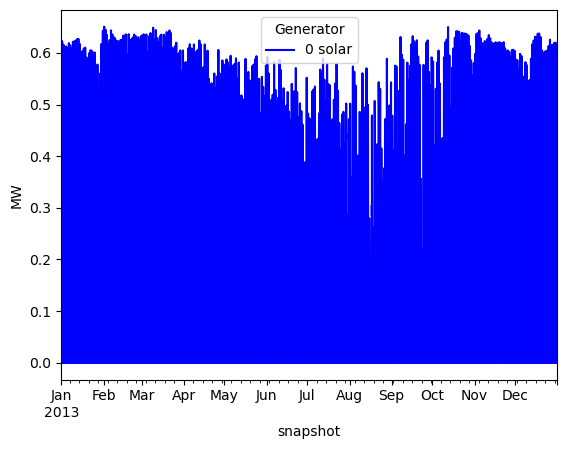

In [21]:
n.generators_t.p_set.plot(color='blue', ylabel='MW')

<AxesSubplot: xlabel='snapshot', ylabel='MW'>

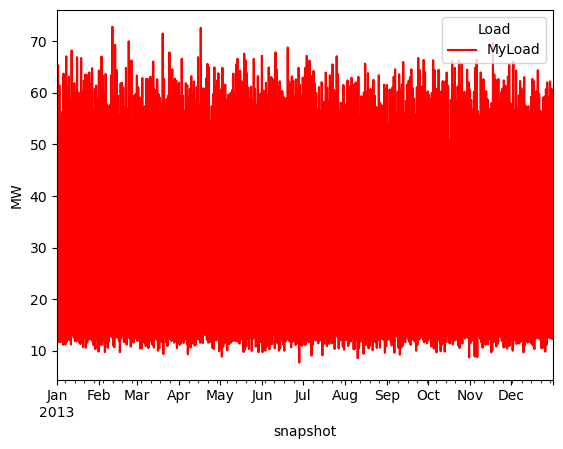

In [22]:
n.loads_t.p_set.plot(color='red', ylabel='MW')

In [13]:
#n.madd("StorageUnit", ["mySU"] , bus="onebus", p_nom=50, capital_cost=300)

In [14]:
n.madd("StorageUnit",["StorUni"], bus="onebus", marginal_cost=10, inflow=50, p_nom_extendable=True, capital_cost=10, p_nom=2000, 
       efficiency_dispatch=0.5, cyclic_state_of_charge=True, state_of_charge_initial=1000)

Index(['StorUni'], dtype='object')

In [23]:
#I want to see my whole network:

print(n)

PyPSA Network
Components:
 - Bus: 1
 - Generator: 1
 - Load: 1
 - StorageUnit: 1
 - SubNetwork: 1
Snapshots: 8760


In [17]:
#Optimization
from pypsa.linopf import ilopf

solver_name="gurobi"

n.lopf(n.snapshots, solver_name=solver_name, pyomo=False)


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.05s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-07
Read LP format model from file C:\Users\denis\AppData\Local\Temp\pypsa-problem-tow1qpgc.lp
Reading time = 0.26 seconds
obj: 87600 rows, 43802 columns, 166440 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 87600 rows, 43802 columns and 166440 nonzeros
Model fingerprint: 0xbd81b26d
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-03, 1e+01]
  Bounds range     [5e+01, 2e+04]
  RHS range        [8e+00, 7e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 66957 rows and 23158 columns
Presolve time: 0.15s
Presolved: 20643 rows, 20644 columns, 88392 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1
 AA' NZ     : 8.145e+04
 Factor NZ  : 2.360e+05 (roughly 20 MB of memory)
 Factor Ops : 3.248e

('warning', 'infeasible or unbounded')

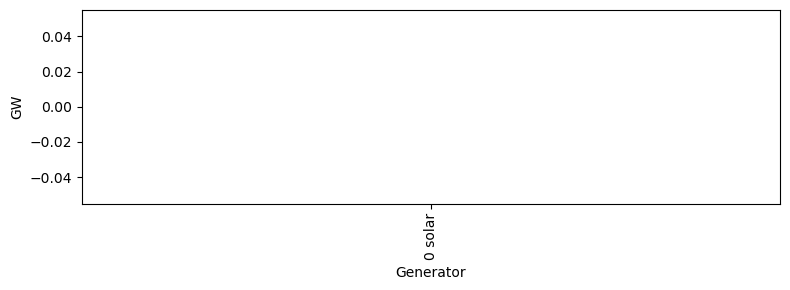

In [18]:
n.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()

In [19]:
print(n.generators.p_nom_opt)

Generator
0 solar    0.0
Name: p_nom_opt, dtype: float64
